 # 数据扩增 
深度学习需要大规模的标注数据集，图像增广技术通过对已有的标注图像进行一系列的随机改变，来产生相似但不相同的训练样本，从而达到扩大训练数据集的目的。   
此外，图像增广技术还可以通过随机改变训练样本来降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，通过对图像进行不同方式的裁剪，使得感兴趣的物体出现在不同位置，减轻模型对物体出现位置的依赖；通过对图像进行旋转，减轻模型对物体放置方向的依赖；此外，还可以通过调整亮度，色彩等等因素，降低模型对色彩的依赖。   

# 使用opencv进行图像加载和处理
进行图像增广的第一步是读取数据

In [267]:
# 导入相应的库
import cv2,glob,os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [268]:
cv2.__version__ #查看opencv版本

'4.2.0'

In [269]:
# 使用glob读取指定路径下的所有文件的文件名
%time train_path = glob.glob('./input/mchar_train/*.png')
train_path.sort()
type(train_path),len(train_path)

CPU times: user 128 ms, sys: 3.01 ms, total: 131 ms
Wall time: 146 ms


(list, 30000)

In [270]:
# glob方式只能读取传入文件夹下的文件，不能读取子文件夹中的文件
# 更好的方式是使用os模块的walk函数构造读取文件夹以及子文件夹下的文件
def dirfiles(filepath):
    lst=[]
    for dirpath,dirnames,filenames in os.walk(filepath):
        for file in filenames:
            fullpath = os.path.join(dirpath,file)
            lst.append(fullpath)
    return lst

In [271]:
%time train_path = dirfiles('./input/mchar_train/')
train_path.sort()
type(train_path),len(train_path)
# 速度上稍慢，但能够读取子文件夹下的文件路径。

CPU times: user 308 ms, sys: 163 ms, total: 471 ms
Wall time: 620 ms


(list, 30000)

In [275]:
train_path[0]

'./input/mchar_train/000000.png'

## 加载图像

In [272]:
# 使用cv2的imread方法读取图像为numpy
image_gray = cv2.imread(train_path[0],cv2.IMREAD_GRAYSCALE) # 参数 cv2.IMREAD_GRAYSCALE 表示导入成灰度图
type(image_gray) 

numpy.ndarray

In [273]:
image_gray.shape
# numpy的 shape 大小等于图片的分辨率

(350, 741)

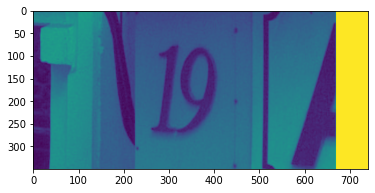

In [274]:
# 使用matplotlib库显示读取的图像
plt.imshow(image_gray)

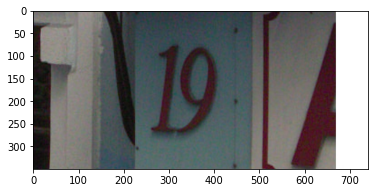

In [276]:
image_bgr = cv2.imread(train_path[0],cv2.IMREAD_COLOR) # 参数 cv2.IMREAD_GRAYSCALE 表示导入成彩色图BGR
plt.imshow(image_bgr)
# 由于cv2默认采用的是BGR格式， 和Matplotlib等很多应用程序所采用的RGB（红绿蓝）不一致，因此显示出来的效果会调换红色和蓝色分量

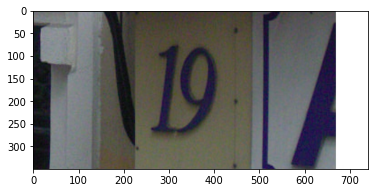

In [277]:
# 正确的做法是读取图片时，通过参数 cv2.COLOR_BGR2RGB 将图片转换为RGB格式
image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

* 查看原始图片发现， image_rgb显示的效果是和打开图片的效果一致的
![IMG](input/mchar_train/000000.png)

## 调整图像大小

In [278]:
# 查看原始图像的分辨率
image_gray.shape

(350, 741)

In [279]:
# 使用resize方法调整图像大小
image_gray_64x128 = cv2.resize(image_gray,(64,128)) # resize的第二个参数格式为（w,h），和numpy数组的shape属性（由imread读取）的顺序（高，宽）不一致
image_gray_64x128.shape

(128, 64)

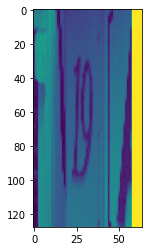

In [280]:
plt.imshow(image_gray_64x128)

## 裁剪图像
图像裁剪是非常基础的图像增广方式。由于cv2将图像读取为numpy，这使得图像的裁剪就变成了numpy数组的切片。

In [281]:
# 读取标注的数字位置
train_json = json.load(open('./input/mchar_train.json'))
train_json['000000.png']

{'height': [219, 219],
 'label': [1, 9],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96]}

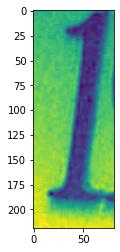

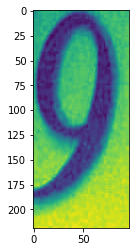

In [282]:
# 由于图像被读取为numpy数组，通过对数组切片就能方便地裁剪图像
# 使用上述数据对原始图片进行裁剪
image_gray_1 = image_gray[77:77+219,246:246+81]
image_gray_2 = image_gray[81:81+219,323:323+96]
plt.imshow(image_gray_1)
plt.show()
plt.imshow(image_gray_2)

## 图像翻转 
需要注意，由于是数字识别，因此翻转的方式不适合用在这里作数据增广。

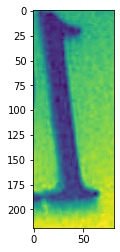

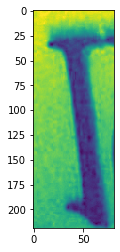

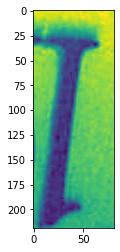

In [283]:
image_gray_1_flip_1 = cv2.flip(image_gray_1,1) # flip函数的第二个参数 1 表示水平翻转
plt.imshow(image_gray_1_flip_1)
plt.show()
image_gray_1_flip_2 = cv2.flip(image_gray_1,0) # 0==垂直翻转
plt.imshow(image_gray_1_flip_2)
plt.show()
image_gray_1_flip_2 = cv2.flip(image_gray_1,-1) # -1==水平+垂直翻转
plt.imshow(image_gray_1_flip_2)
plt.show()

## 添加随机高斯噪声
由于cv2将图片读取为numpy数组，如果需要添加噪声，只需要生成形状相同且满足高斯分布的随机数组，然后和原始图片的numpy数组相加就可以了。

In [284]:
# 生成随机数组
noise_gauss = np.random.normal(image_gray_1.mean(),image_gray_1.var()**0.5,image_gray_1.shape)
image_gray_1_add_noise = noise_gauss+image_gray_1

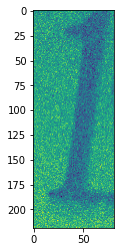

In [285]:
plt.imshow(image_gray_1_add_noise)
# 观察发现，图片变得更加模糊了。

## 图像去噪


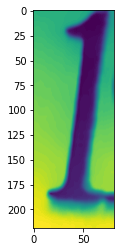

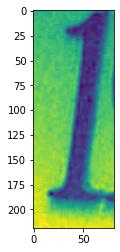

In [286]:
plt.imshow(cv2.fastNlMeansDenoising(image_gray_1,10,10,7,21))
plt.show()
# 第二个参数决定滤波器强度，较高的值可以更好的消除噪声，但也会删除图像的细节
# 第三个参数和第二个参数一致，但仅适用于彩色图像
# 其他参数说明参见函数定义。
plt.imshow(image_gray_1)
plt.show()
# 对比可见，相对原始图片，去噪后的图片更加易于辨识

In [253]:
cv2.fastNlMeansDenoising??
#cv2.fastNlMeansDenoisingColored??
#cv2.fastNlMeansDenoisingMulti??
#cv2.fastNlMeansDenoisingColoredMulti??

## 平滑图像处理
平滑图像处理是将每个像素的值转换为其相邻像素的平均值。

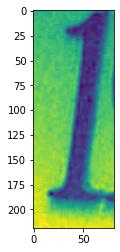

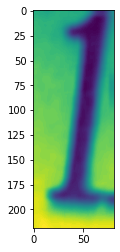

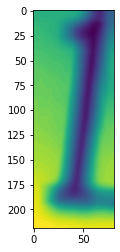

In [288]:
# 使用cv2.blur函数对图像进行平滑处理。
# 第二个参数表示“核”的大小--核越大，得到的结果越平滑，看起来也就越模糊
plt.imshow(image_gray_1)
plt.show() # 原始图片，作为对比
image_gray_1_blurry = cv2.blur(image_gray_1,(10,10))
plt.imshow(image_gray_1_blurry)
plt.show()
image_gray_1_blurry = cv2.blur(image_gray_1,(20,20))
plt.imshow(image_gray_1_blurry)

## 图像锐化
在平滑处理中，使用的是一个平均化的核，例如，blur函数的第二个参数(10,10)表示一个10\*10的值为0.1的矩阵。

In [289]:
kernel = np.ones((10,10))*0.01
kernel

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [290]:
# 除了使用blur函数，使用filter2D函数同样可以实现相同的图像平滑处理的效果
cv2.blur(image_gray_1,(10,10)) == cv2.filter2D(image_gray_1,-1,kernel)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [291]:
# 此外，在改变传入的核，将平均化处理的核改为突出显示的核， 则可实现图像锐化的目的
# 首先创建一个锐化图像的核
kernel_sharp = np.array([[0,-1,0],
                         [-1,5,-1],
                         [0,-1,0]])

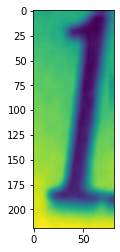

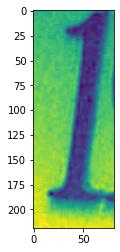

In [292]:
# 使用上述核锐化图像
image_gray_1_sharp = cv2.filter2D(image_gray_1,-1,kernel)
plt.imshow(image_gray_1_sharp)
plt.show()
plt.imshow(image_gray_1)
plt.show()# 和原始图片作对比

In [ ]:
# opencv中的图像处理方式还有很多，留待后续慢慢学习。

# torchvision中的数据扩增方法
torchvision中常见的数据扩增方法：
* transforms.CenterCrop      对图片中心进行裁剪      
    中心化裁剪是指依给定的size从图片中心进行裁剪，本次任务并不适用。
* transforms.ColorJitter      对图像颜色的对比度、饱和度和零度进行变换      
    
* transforms.FiveCrop     对图像四个角和中心进行裁剪得到五分图像     
    本次任务不适用。
* transforms.Grayscale      对图像进行灰度变换    
* transforms.Pad        使用固定值进行像素填充     
* transforms.RandomAffine      随机仿射变换    
    对图片进行随机仿射变换，
* transforms.RandomCrop      随机区域裁剪     
    本次任务不适用。
* transforms.RandomHorizontalFlip      随机水平翻转  
    该方法对本次数字识别任务不适用。     
* transforms.RandomRotation     随机旋转     
    该方法对本次数字识别任务不适用。
* transforms.RandomVerticalFlip     随机垂直翻转 
    本次任务可使用，但旋转角度不应过大。

In [257]:
import os, sys, glob, shutil, json, cv2, torch
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 如果有GPU, 指定只用第一个GPU
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
%pylab inline

torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [258]:
# 定定义读取数据集
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')#转为RGB #img=cv2.imread((self.img_path[index]),cv2.IMREAD_GRAYSCALE) #cv2读取图片不行，须是PIL格式

        if self.transform is not None:
            img = self.transform(img)
        
        #原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (5 - len(lbl)) * [10] # 最长标签设定为5， 设为更短会训练得更快
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

In [266]:
# 读取数据集
train_path = glob.glob('./input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('./input/mchar_train.json')) # 将json文件读取为字典。
train_label = [train_json[x]['label'] for x in train_json] # 字典中的键值对是没有前后顺序的，这样是否会导致顺序错乱？
# 直接将读取json得到的字典转为df--得到的结果是按照字典的键排序的，可以用于替换上述方式。
# df_json = pd.DataFrame(train_json).T
# train_label = df_json.label.values
print(len(train_path), len(train_label))

# 读取训练数据
train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),#缩放到固定尺寸
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),#随机颜色变换
                    transforms.RandomRotation(10),#加入随机旋转
                    transforms.ToTensor(),#将图片转换为pytorch 的 tensor
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#对图像像素进行归一化
    ])), 
    batch_size=40, # batch_size 设置为 40 
    shuffle=True, 
    num_workers=10, # 设置线程数， win下要注释掉
)

30000 30000


In [ ]:
### json文件的读取和处理

In [301]:
# 直接将读取json得到的字典转为df--得到的结果是按照字典的键排序的，可以用于替换上述方式。
df_json = pd.DataFrame(train_json).T.sort_index()
display(df_json.head(10))
display(df_json.tail(10))
# 并不适于使用，需将每列按值的个数拆分为相应的行

,height,label,left,top,width
000000.png,"[219, 219]","[1, 9]","[246, 323]","[77, 81]","[81, 96]"
000001.png,"[32, 32]","[2, 3]","[77, 98]","[29, 25]","[23, 26]"
000002.png,"[15, 15]","[2, 5]","[17, 25]","[5, 5]","[8, 9]"
000003.png,"[34, 34]","[9, 3]","[57, 72]","[13, 13]","[15, 13]"
000004.png,"[46, 46]","[3, 1]","[52, 74]","[7, 10]","[21, 15]"
000005.png,"[21, 21]","[3, 3]","[28, 38]","[6, 8]","[10, 11]"
000006.png,"[32, 32]","[2, 8]","[35, 47]","[10, 11]","[13, 13]"
000007.png,"[15, 15, 15]","[7, 4, 4]","[17, 25, 31]","[4, 4, 3]","[7, 6, 7]"
000008.png,"[24, 24, 24]","[1, 2, 8]","[19, 29, 38]","[4, 4, 5]","[14, 13, 17]"
000009.png,"[27, 27]","[1, 6]","[25, 34]","[6, 4]","[9, 14]"


,height,label,left,top,width
029990.png,"[21, 21]","[9, 7]","[21, 35]","[4, 3]","[12, 11]"
029991.png,"[31, 31]","[6, 1]","[55, 76]","[15, 17]","[19, 10]"
029992.png,"[33, 33]","[8, 8]","[34, 53]","[9, 10]","[14, 12]"
029993.png,"[18, 18]","[2, 9]","[31, 40]","[10, 10]","[7, 7]"
029994.png,[34.0],[5],[29.0],[3.0],[17.0]
029995.png,[39.0],[9],[74.0],[8.0],[25.0]
029996.png,"[35, 35]","[5, 3]","[72, 100]","[32, 19]","[25, 23]"
029997.png,"[27, 27]","[2, 7]","[22, 36]","[1, 1]","[12, 14]"
029998.png,"[58, 58]","[1, 6]","[73, 91]","[26, 16]","[25, 29]"
029999.png,"[32, 32]","[3, 5]","[51, 71]","[16, 19]","[22, 19]"


In [300]:
# 训练集中， 包含数字最多的图片有6个数字。 
print(df_json.label.str.len().idxmax())
df_json.loc[df_json.label.str.len().idxmax(),:]

029929.png


height    [18, 18, 18, 18, 18, 18]
label           [1, 3, 5, 4, 5, 8]
left      [18, 24, 30, 37, 48, 56]
top             [3, 3, 4, 3, 4, 4]
width          [5, 6, 8, 10, 9, 8]
Name: 029929.png, dtype: object

In [149]:
df_json.iloc[11215,:].astype(str).str.replace('[','').str.replace(']','').str.split(',',expand = True)

,0,1
height,17,17
label,1,5
left,18,24
top,1,2
width,7,10


In [98]:
pd.DataFrame(train_json['000000.png'],index=['000000.png']*2).set_index('label', append = True)

height  left  top  width
           label                          
000000.png 1         219   246   77     81
           9         219   323   81     96

In [101]:
train_json['000000.png']

{'height': [219, 219],
 'label': [1, 9],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96]}

In [102]:
len(train_json['000000.png']['label'])

2

In [127]:
df = pd.DataFrame()
for key in list(train_json.keys())[:10]:
    df_temp = pd.DataFrame(train_json[key],index=[key]*len(train_json[key]['label'])).set_index('label', append = True)
    df = pd.concat([df,df_temp])
print(df.shape)
df.head()

(22, 4)


height  left  top  width
           label                          
000000.png 1         219   246   77     81
           9         219   323   81     96
000001.png 2          32    77   29     23
           3          32    98   25     26
000002.png 2          15    17    5      8

In [120]:
def f(key_list):
    lst = []
    for key in key_list:
        lst.append(pd.DataFrame(train_json[key],index=[key]*len(train_json[key]['label'])).set_index('label', append = True))
        df = pd.concat(lst)
    return df 

In [122]:
print(list(train_json.keys())[:20])

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png']


In [126]:
%time df1 = f(list(train_json.keys())[:2000])
print(df1.shape)
df1.sample(20)
# CPU times: user 12.7 s, sys: 63.6 ms, total: 12.8 s  Wall time: 13.2 s ---200个
# CPU times: user 20min 5s, sys: 5.88 s, total: 20min 11s Wall time: 20min 32s ---2000个--太慢了

CPU times: user 20min 5s, sys: 5.88 s, total: 20min 11s
Wall time: 20min 32s
(4434, 4)


height   left   top  width
           label                            
000000.png 1       219.0  246.0  77.0   81.0
           9       219.0  323.0  81.0   96.0
000001.png 2        32.0   77.0  29.0   23.0
           3        32.0   98.0  25.0   26.0
000002.png 2        15.0   17.0   5.0    8.0

In [151]:
df1.head(20)

height   left   top  width
           label                            
000000.png 1       219.0  246.0  77.0   81.0
           9       219.0  323.0  81.0   96.0
000001.png 2        32.0   77.0  29.0   23.0
           3        32.0   98.0  25.0   26.0
000002.png 2        15.0   17.0   5.0    8.0
           5        15.0   25.0   5.0    9.0
000003.png 9        34.0   57.0  13.0   15.0
           3        34.0   72.0  13.0   13.0
000004.png 3        46.0   52.0   7.0   21.0
           1        46.0   74.0  10.0   15.0
000005.png 3        21.0   28.0   6.0   10.0
           3        21.0   38.0   8.0   11.0
000006.png 2        32.0   35.0  10.0   13.0
           8        32.0   47.0  11.0   13.0
000007.png 7        15.0   17.0   4.0    7.0
           4        15.0   25.0   4.0    6.0
           4        15.0   31.0   3.0    7.0
000008.png 1        24.0   19.0   4.0   14.0
           2        24.0   29.0   4.0   13.0
           8        24.0   38.0   5.0   17.0

In [152]:
import torchvision.transforms as transforms

In [153]:
print(dir(transforms))

['CenterCrop', 'ColorJitter', 'Compose', 'FiveCrop', 'Grayscale', 'Lambda', 'LinearTransformation', 'Normalize', 'Pad', 'RandomAffine', 'RandomApply', 'RandomChoice', 'RandomCrop', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomOrder', 'RandomPerspective', 'RandomResizedCrop', 'RandomRotation', 'RandomSizedCrop', 'RandomVerticalFlip', 'Resize', 'Scale', 'TenCrop', 'ToPILImage', 'ToTensor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'functional', 'transforms']
